In [1]:
# To prevent unnecessary warnings (e.g. FutureWarnings in TensorFlow)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import json
import requests
from tqdm import tqdm

print(tf.__version__)

2.14.0


In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\nTrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('Test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))

4422102/4422102 [==============================] - 1s 0us/step

Train_images.shape: (60000, 28, 28), of uint8
Test_images.shape: (10000, 28, 28), of uint8


In [3]:
train_images_3ch = np.stack([train_images]*3, axis=-1)
test_images_3ch = np.stack([test_images]*3, axis=-1)

print('\nTrain_images.shape: {}, of {}'.format(train_images_3ch.shape, train_images_3ch.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_3ch.shape, test_images_3ch.dtype))


Train_images.shape: (60000, 28, 28, 3), of uint8
Test_images.shape: (10000, 28, 28, 3), of uint8


In [4]:
def resize_image_array(img, img_size_dims):
  img = tf.image.resize(
      img, img_size_dims, method=tf.image.ResizeMethod.BICUBIC)
  img = np.array(img, dtype=np.float32)
  return img

In [5]:
%%time

IMG_DIMS = (32, 32)

train_images_3ch = np.array([resize_image_array(img, img_size_dims=IMG_DIMS) for img in train_images_3ch])
test_images_3ch = np.array([resize_image_array(img, img_size_dims=IMG_DIMS) for img in test_images_3ch])

print('\nTrain_images.shape: {}, of {}'.format(train_images_3ch.shape, train_images_3ch.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_3ch.shape, test_images_3ch.dtype))


Train_images.shape: (60000, 32, 32, 3), of float32
Test_images.shape: (10000, 32, 32, 3), of float32
CPU times: total: 11.4 s
Wall time: 28.5 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

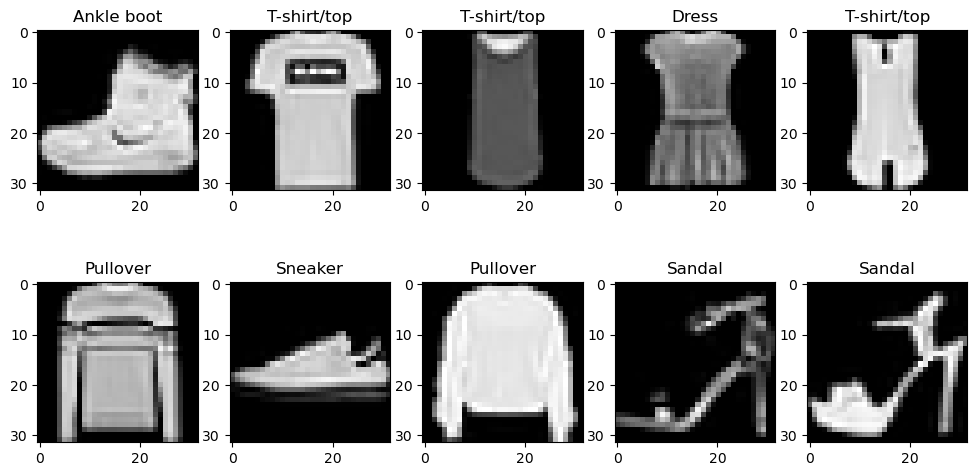

In [6]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
c = 0
for i in range(10):
  idx = i // 5
  idy = i % 5 
  ax[idx, idy].imshow(train_images_3ch[i]/255.)
  ax[idx, idy].set_title(class_names[train_labels[i]])

In [7]:
# define input shape
INPUT_SHAPE = (32, 32, 3)

# get the VGG19 model
vgg_layers = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, 
                                               input_shape=INPUT_SHAPE)

vgg_layers.summary()

80134624/80134624 [==============================] - 17s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                             

In [8]:
# Fine-tune all the layers
for layer in vgg_layers.layers:
  layer.trainable = True

# Check the trainable status of the individual layers
for layer in vgg_layers.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x000002161B8FF280> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002161BD83B80> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002161BA78340> True
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000002161BA79000> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002161BA796F0> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002161BA79BA0> True
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000002161BA7B1F0> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002161BA79FC0> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002161BA7BE50> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002161BA79ED0> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002161BAF4820> True
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000002161BAF63E0> True
<keras.src.l

In [9]:
# define sequential model
model = tf.keras.models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_layers)

# add flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))

# add output layer
model.add(tf.keras.layers.Dense(10))

# compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

# view model layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                2

In [10]:
EPOCHS = 1
train_images_3ch_scaled = train_images_3ch / 255.
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               patience=2, 
                                               restore_best_weights=True,
                                               verbose=1)

history = model.fit(train_images_3ch_scaled, train_labels,
                    batch_size=32,
                    callbacks=[es_callback], 
                    validation_split=0.1, epochs=EPOCHS,
                    verbose=1)

1688/1688 [==============================] - 1945s 1s/step - loss: 0.5164 - accuracy: 0.8285 - val_loss: 0.3228 - val_accuracy: 0.8868


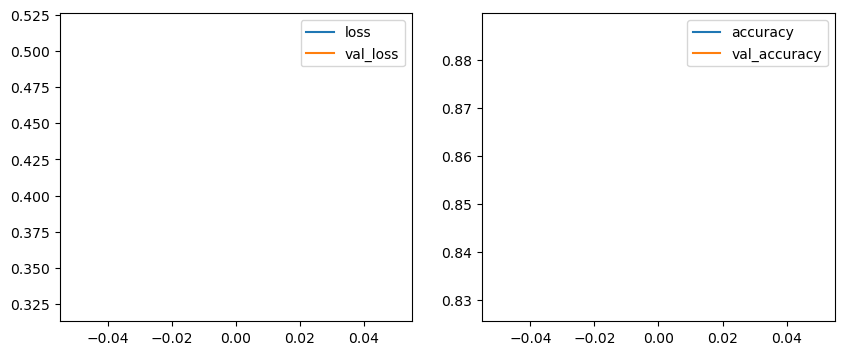

In [11]:
import pandas as pd

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', 
                                      ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', 
                                              ax=ax[1]);

In [12]:
test_images_3ch_scaled = test_images_3ch / 255.
predictions = model.predict(test_images_3ch_scaled)
predictions[:5]

313/313 [==============================] - 24s 76ms/step


array([[-2.71296769e-01, -3.13521194e+00, -1.24219632e+00,
        -2.60697389e+00, -1.83831239e+00,  3.21890771e-01,
        -2.89423537e+00,  2.60344028e+00, -1.91819012e+00,
         6.85145521e+00],
       [-1.34067833e+00, -1.43329287e+00,  6.21238661e+00,
        -1.38286757e+00,  1.84600401e+00, -1.69512963e+00,
         7.47495532e-01, -2.57738805e+00, -2.32702446e+00,
        -2.26656222e+00],
       [-2.01526928e+00,  1.48496275e+01, -4.62610602e-01,
        -1.78329957e+00, -3.60150248e-01, -7.55641639e-01,
         1.87879950e-01, -3.53515315e+00, -3.60225868e+00,
        -4.93655920e+00],
       [-2.08790398e+00,  1.16519012e+01, -4.81184065e-01,
        -7.55001485e-01, -2.70279676e-01, -8.43633294e-01,
         4.27574711e-03, -2.93929505e+00, -2.94112468e+00,
        -4.44789410e+00],
       [ 8.61703217e-01, -1.52468979e+00,  8.92663002e-02,
        -1.61581919e-01,  1.45748103e+00, -2.24259973e+00,
         4.09872150e+00, -1.71668231e+00, -9.76689875e-01,
        -2.

In [13]:
prediction_labels = np.argmax(predictions, axis=1)
prediction_labels[:5]

array([9, 2, 1, 1, 6], dtype=int64)

In [14]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(test_labels, prediction_labels, 
                            target_names=class_names))
pd.DataFrame(confusion_matrix(test_labels, prediction_labels), 
             index=class_names, columns=class_names)

              precision    recall  f1-score   support

 T-shirt/top       0.90      0.77      0.83      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.92      0.72      0.81      1000
       Dress       0.88      0.89      0.88      1000
        Coat       0.76      0.88      0.82      1000
      Sandal       0.97      0.98      0.98      1000
       Shirt       0.64      0.78      0.70      1000
     Sneaker       0.91      0.98      0.94      1000
         Bag       0.99      0.97      0.98      1000
  Ankle boot       0.99      0.91      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,771,2,11,31,10,0,171,0,4,0
Trouser,0,974,0,18,5,0,2,0,1,0
Pullover,9,1,719,10,140,0,121,0,0,0
Dress,5,3,6,890,50,0,46,0,0,0
Coat,1,2,11,21,884,0,81,0,0,0
Sandal,0,0,0,0,0,978,0,20,0,2
Shirt,69,0,34,40,75,0,779,0,3,0
Sneaker,0,0,0,0,0,14,0,980,0,6
Bag,3,1,0,2,5,3,16,0,970,0
Ankle boot,0,0,0,0,0,11,0,80,0,909


In [15]:
def get_model_preds(input_image, class_names_map, model):
  preds = model.predict(input_image)
  # Convert logits to probabilities by taking softmax.
  probs = np.exp(preds) / np.sum(np.exp(preds))
  top_idx = np.argsort(-probs)[0][0]
  top_prob = -np.sort(-probs)[0][0]
  top_class = np.array(class_names_map)[top_idx]
  return top_class, top_prob


def generate_adversarial_pattern(input_image, image_label_idx, model, loss_func):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_func(image_label_idx, prediction)
  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad


def perform_adversarial_attack_fgsm(input_image, image_label_idx, cnn_model, class_names_map, loss_func, eps=0.01):
  # basic image shaping
  input_image = np.array([input_image])
  tf_img = tf.convert_to_tensor(input_image)
  # predict class before adversarial attack
  ba_pred_class, ba_pred_prob = get_model_preds(tf_img, class_names_map, cnn_model)
  # generate adversarial image
  adv_pattern = generate_adversarial_pattern(tf_img, image_label_idx, model, loss_func)
  clip_adv_pattern = tf.clip_by_value(adv_pattern, clip_value_min=0., clip_value_max=1.)

  perturbed_img = tf_img + (eps * adv_pattern)
  perturbed_img = tf.clip_by_value(perturbed_img, clip_value_min=0., clip_value_max=1.)
  # predict class after adversarial attack
  aa_pred_class, aa_pred_prob = get_model_preds(perturbed_img, class_names_map, cnn_model)

  # visualize results
  fig, ax = plt.subplots(1, 3, figsize=(15, 4))
  ax[0].imshow(tf_img[0].numpy())
  ax[0].set_title('Before Adversarial Attack\nTrue:{}  Pred:{}  Prob:{:.3f}'.format(class_names_map[image_label_idx],
                                                                                    ba_pred_class,
                                                                                    round(ba_pred_prob, 3)))
  
  ax[1].imshow(clip_adv_pattern[0].numpy())
  ax[1].set_title('Adversarial Pattern -  EPS:{}'.format(eps))
  
  ax[2].imshow(perturbed_img[0].numpy())
  ax[2].set_title('After Adversarial Attack\nTrue:{}  Pred:{}  Prob:{:.3f}'.format(class_names_map[image_label_idx],
                                                                                    aa_pred_class,
                                                                                    aa_pred_prob))

In [16]:
scc = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [17]:
def show_adv_attack_example(image_idx, image_dataset, 
                            image_labels, cnn_model,
                            class_names, loss_fn, eps):
  sample_apparel_img = image_dataset[image_idx]
  sample_apparel_labelidx = image_labels[image_idx]
  perform_adversarial_attack_fgsm(input_image=sample_apparel_img, 
                                  image_label_idx=sample_apparel_labelidx, 
                                  cnn_model=cnn_model, 
                                  class_names_map=class_names,
                                  loss_func=loss_fn, eps=eps)

1/1 [==============================] - 0s 24ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


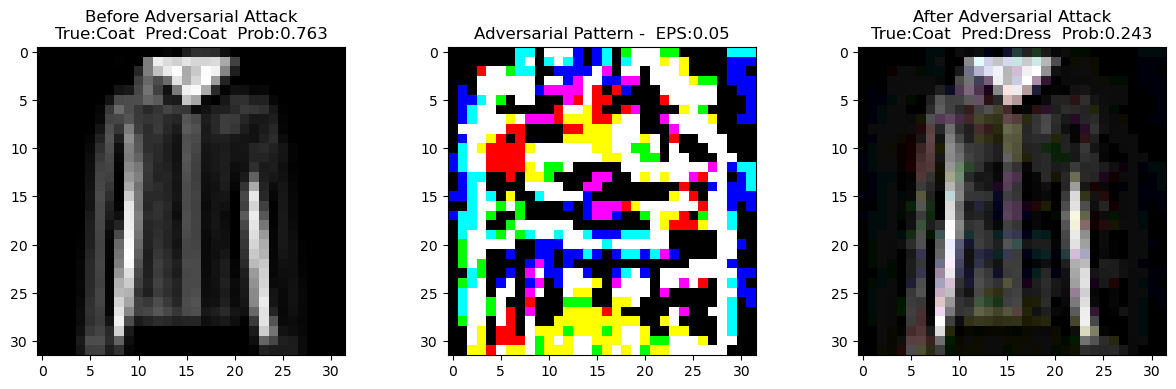

In [18]:
show_adv_attack_example(6, test_images_3ch_scaled, 
                        test_labels, model,
                        class_names, scc, 0.05)

1/1 [==============================] - 0s 25ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


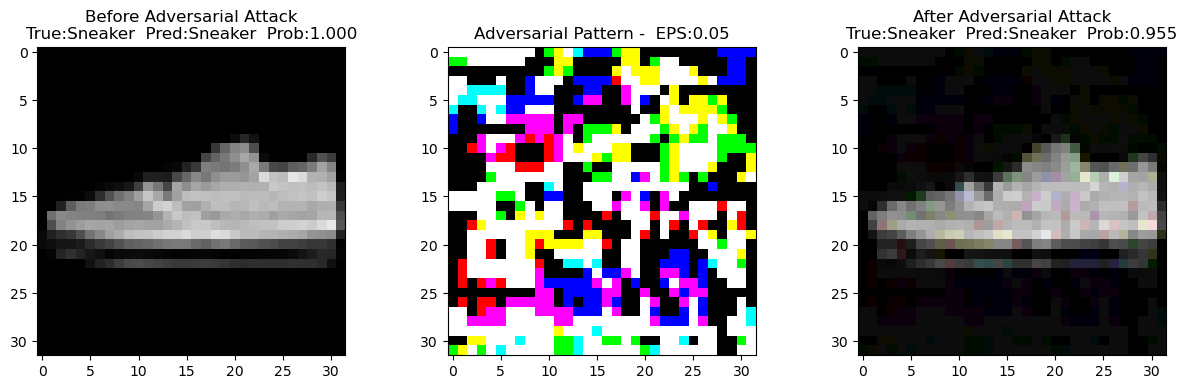

In [19]:
show_adv_attack_example(60, test_images_3ch_scaled, 
                        test_labels, model,
                        class_names, scc, 0.05)

1/1 [==============================] - 0s 23ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


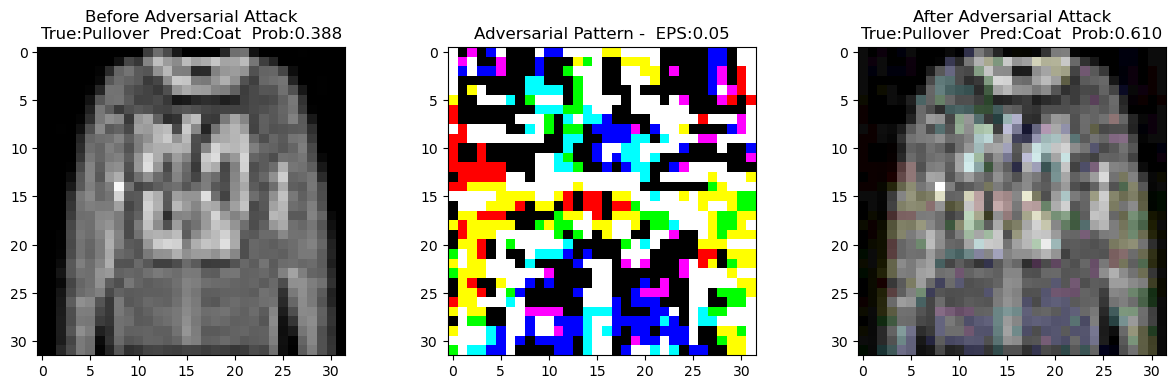

In [20]:
show_adv_attack_example(500, test_images_3ch_scaled, 
                        test_labels, model,
                        class_names, scc, 0.05)

1/1 [==============================] - 0s 26ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


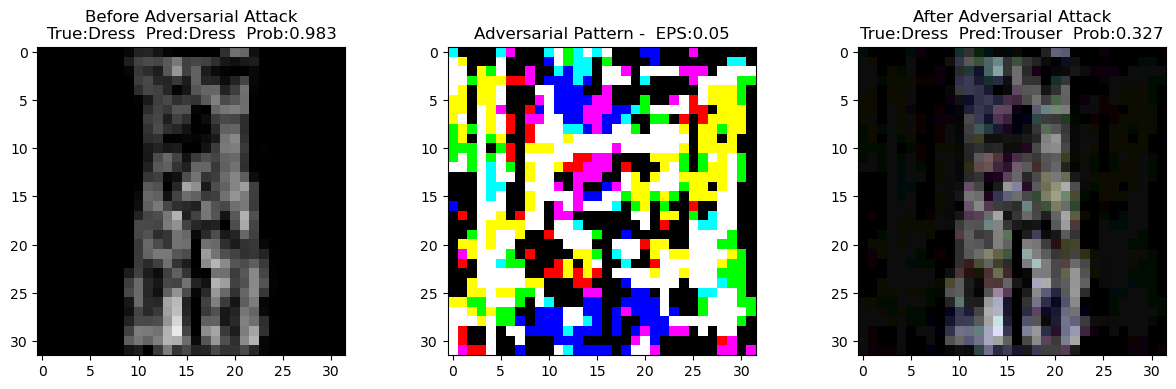

In [21]:
show_adv_attack_example(560, test_images_3ch_scaled, 
                        test_labels, model,
                        class_names, scc, 0.05)

In [22]:
!pip install neural-structured-learning

     -------------------------------------- 128.6/128.6 kB 3.8 MB/s eta 0:00:00


In [23]:
import neural_structured_learning as nsl

In [24]:
adv_multiplier = 0.45
adv_step_size = 0.95
adv_grad_norm = 'l2'

adversarial_config = nsl.configs.make_adv_reg_config(
  multiplier=adv_multiplier,
  adv_step_size=adv_step_size,
  adv_grad_norm=adv_grad_norm
)

In [25]:
adversarial_config

AdvRegConfig(multiplier=0.45, adv_neighbor_config=AdvNeighborConfig(feature_mask=None, adv_step_size=0.95, adv_grad_norm=<NormType.L2: 'l2'>, clip_value_min=None, clip_value_max=None, pgd_iterations=1, pgd_epsilon=None, random_init=False))

In [26]:
vgg_layers = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, 
                                               input_shape=INPUT_SHAPE)

# Fine-tune all the layers
for layer in vgg_layers.layers:
  layer.trainable = True

# Check the trainable status of the individual layers
for layer in vgg_layers.layers:
  print(layer, layer.trainable)

# define sequential model
base_model = tf.keras.models.Sequential()

# Add the vgg convolutional base model
base_model.add(vgg_layers)

# add flatten layer
base_model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
base_model.add(tf.keras.layers.Dense(256, activation='relu'))
base_model.add(tf.keras.layers.Dropout(rate=0.3))
base_model.add(tf.keras.layers.Dense(256, activation='relu'))
base_model.add(tf.keras.layers.Dropout(rate=0.3))

# add output layer
base_model.add(tf.keras.layers.Dense(10))

<keras.src.engine.input_layer.InputLayer object at 0x000002167AE2BB20> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002167B9E54B0> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002167AE28BE0> True
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000002167B9E5C30> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002167B9E6980> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002167B9E6E00> True
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000002167B9E7010> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002167B9E7790> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002167B9E78E0> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002167ADA8700> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x000002167B9E79A0> True
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000002167BA09FF0> True
<keras.src.l

In [27]:
adv_model = nsl.keras.AdversarialRegularization(
  base_model,
  label_keys=['label'],
  adv_config=adversarial_config
)

In [28]:
adv_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_images_3ch_scaled, 
                                                  train_labels, 
                                                  test_size=0.1, 
                                                  random_state=42)
batch_size = 256

train_data = tf.data.Dataset.from_tensor_slices(
  {'input': X_train, 
    'label': tf.convert_to_tensor(y_train, dtype='float32')}).batch(batch_size)

val_data = tf.data.Dataset.from_tensor_slices(
  {'input': X_val, 
    'label': tf.convert_to_tensor(y_val, dtype='float32')}).batch(batch_size)


val_steps = X_val.shape[0] / batch_size

In [30]:
EPOCHS = 1

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               patience=2, 
                                               restore_best_weights=False,
                                               verbose=1)

history = adv_model.fit(train_data, validation_data=val_data,
                        validation_steps=val_steps, 
                        batch_size=batch_size,
                        callbacks=[es_callback], 
                        epochs=EPOCHS,
                        verbose=1)

211/211 [==============================] - 2900s 14s/step - loss: 1.2617 - sparse_categorical_crossentropy: 0.7647 - sparse_categorical_accuracy: 0.7328 - scaled_adversarial_loss: 0.4971 - val_loss: 0.7350 - val_sparse_categorical_crossentropy: 0.3890 - val_sparse_categorical_accuracy: 0.8617 - val_scaled_adversarial_loss: 0.3460


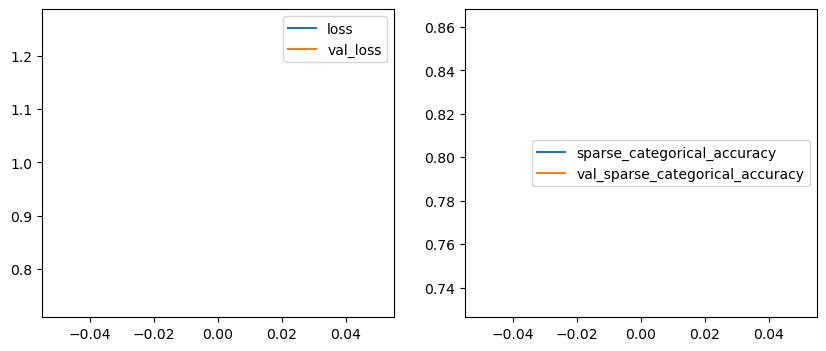

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', 
                                      ax=ax[0])
history_df[['sparse_categorical_accuracy', 
            'val_sparse_categorical_accuracy']].plot(kind='line', 
                                                     ax=ax[1]);

In [32]:
predictions = adv_model.base_model.predict(test_images_3ch_scaled)
prediction_labels = np.argmax(predictions, axis=1)
print(classification_report(test_labels, prediction_labels, 
                            target_names=class_names))
pd.DataFrame(confusion_matrix(test_labels, prediction_labels), 
             index=class_names, columns=class_names)

313/313 [==============================] - 29s 91ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.72      0.89      0.80      1000
     Trouser       1.00      0.96      0.98      1000
    Pullover       0.76      0.81      0.78      1000
       Dress       0.84      0.88      0.86      1000
        Coat       0.78      0.72      0.75      1000
      Sandal       0.98      0.96      0.97      1000
       Shirt       0.65      0.47      0.54      1000
     Sneaker       0.94      0.94      0.94      1000
         Bag       0.94      0.98      0.96      1000
  Ankle boot       0.95      0.96      0.96      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.85     10000
weighted avg       0.86      0.86      0.85     10000



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,894,0,16,39,5,0,30,1,15,0
Trouser,0,961,0,30,2,0,5,0,2,0
Pullover,15,1,806,12,92,0,69,0,5,0
Dress,45,3,9,880,21,0,38,0,4,0
Coat,1,0,112,47,725,0,109,0,6,0
Sandal,0,0,0,0,0,959,0,32,2,7
Shirt,281,0,110,35,81,0,469,0,24,0
Sneaker,0,0,0,0,0,12,0,944,0,44
Bag,0,0,2,4,3,1,4,1,984,1
Ankle boot,0,0,0,0,0,4,0,31,1,964


In [33]:
def generate_perturbed_images(input_images, image_label_idxs, model, loss_func, eps=0.01):
  perturbed_images = []
  # don't use list on large data - used just to view fancy progress-bar
  for image, label in tqdm(list(zip(input_images, image_label_idxs))): 
    image = tf.convert_to_tensor(np.array([image]))
    adv_pattern = generate_adversarial_pattern(image, label, model, loss_func)
    perturbed_img = image + (eps * adv_pattern)
    perturbed_img = tf.clip_by_value(perturbed_img, clip_value_min=0., clip_value_max=1.)[0]
    perturbed_images.append(perturbed_img)

  return tf.convert_to_tensor(perturbed_images)

In [34]:
perturbed_test_imgs = generate_perturbed_images(input_images=test_images_3ch_scaled, 
                                                image_label_idxs=test_labels, model=model, 
                                                loss_func=scc, eps=0.05)

100%|██████████| 10000/10000 [23:59<00:00,  6.95it/s]


In [35]:
predictions = model.predict(perturbed_test_imgs)
prediction_labels = np.argmax(predictions, axis=1)
print(classification_report(test_labels, prediction_labels, 
                            target_names=class_names))
pd.DataFrame(confusion_matrix(test_labels, prediction_labels), 
             index=class_names, columns=class_names)

313/313 [==============================] - 30s 96ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.21      0.05      0.08      1000
     Trouser       0.94      0.81      0.87      1000
    Pullover       0.04      0.01      0.01      1000
       Dress       0.52      0.47      0.49      1000
        Coat       0.17      0.21      0.19      1000
      Sandal       0.61      0.71      0.66      1000
       Shirt       0.09      0.26      0.13      1000
     Sneaker       0.48      0.44      0.46      1000
         Bag       0.95      0.59      0.73      1000
  Ankle boot       0.72      0.67      0.69      1000

    accuracy                           0.42     10000
   macro avg       0.47      0.42      0.43     10000
weighted avg       0.47      0.42      0.43     10000



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,51,3,15,86,20,0,819,0,6,0
Trouser,0,807,1,153,11,0,27,0,1,0
Pullover,5,1,7,13,331,0,642,0,1,0
Dress,31,41,10,465,191,0,258,0,3,1
Coat,1,3,69,77,211,0,638,0,1,0
Sandal,0,0,0,1,0,706,9,243,5,36
Shirt,142,5,75,82,422,0,263,0,11,0
Sneaker,0,0,0,0,1,325,3,442,6,223
Bag,9,2,10,24,62,18,280,0,591,4
Ankle boot,0,0,0,1,0,103,2,228,0,666


In [36]:
predictions = adv_model.base_model.predict(perturbed_test_imgs)
prediction_labels = np.argmax(predictions, axis=1)
print(classification_report(test_labels, prediction_labels, 
                            target_names=class_names))
pd.DataFrame(confusion_matrix(test_labels, prediction_labels), 
             index=class_names, columns=class_names)

313/313 [==============================] - 28s 87ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.67      0.75      0.71      1000
     Trouser       0.98      0.91      0.94      1000
    Pullover       0.53      0.36      0.43      1000
       Dress       0.71      0.77      0.74      1000
        Coat       0.47      0.44      0.45      1000
      Sandal       0.89      0.84      0.86      1000
       Shirt       0.26      0.32      0.29      1000
     Sneaker       0.80      0.81      0.80      1000
         Bag       0.93      0.95      0.94      1000
  Ankle boot       0.87      0.90      0.88      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.70     10000
weighted avg       0.71      0.70      0.70     10000



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,752,2,18,84,7,0,120,0,17,0
Trouser,2,909,0,77,2,0,8,0,2,0
Pullover,15,1,361,14,231,0,372,0,6,0
Dress,83,15,9,769,59,0,59,0,5,1
Coat,6,0,146,77,436,0,328,0,7,0
Sandal,0,0,0,1,0,840,0,125,6,28
Shirt,260,2,140,55,194,0,318,0,31,0
Sneaker,0,0,0,0,0,83,0,807,1,109
Bag,3,0,5,6,4,3,22,3,953,1
Ankle boot,0,0,0,0,0,19,0,79,1,901


1/1 [==============================] - 0s 33ms/step


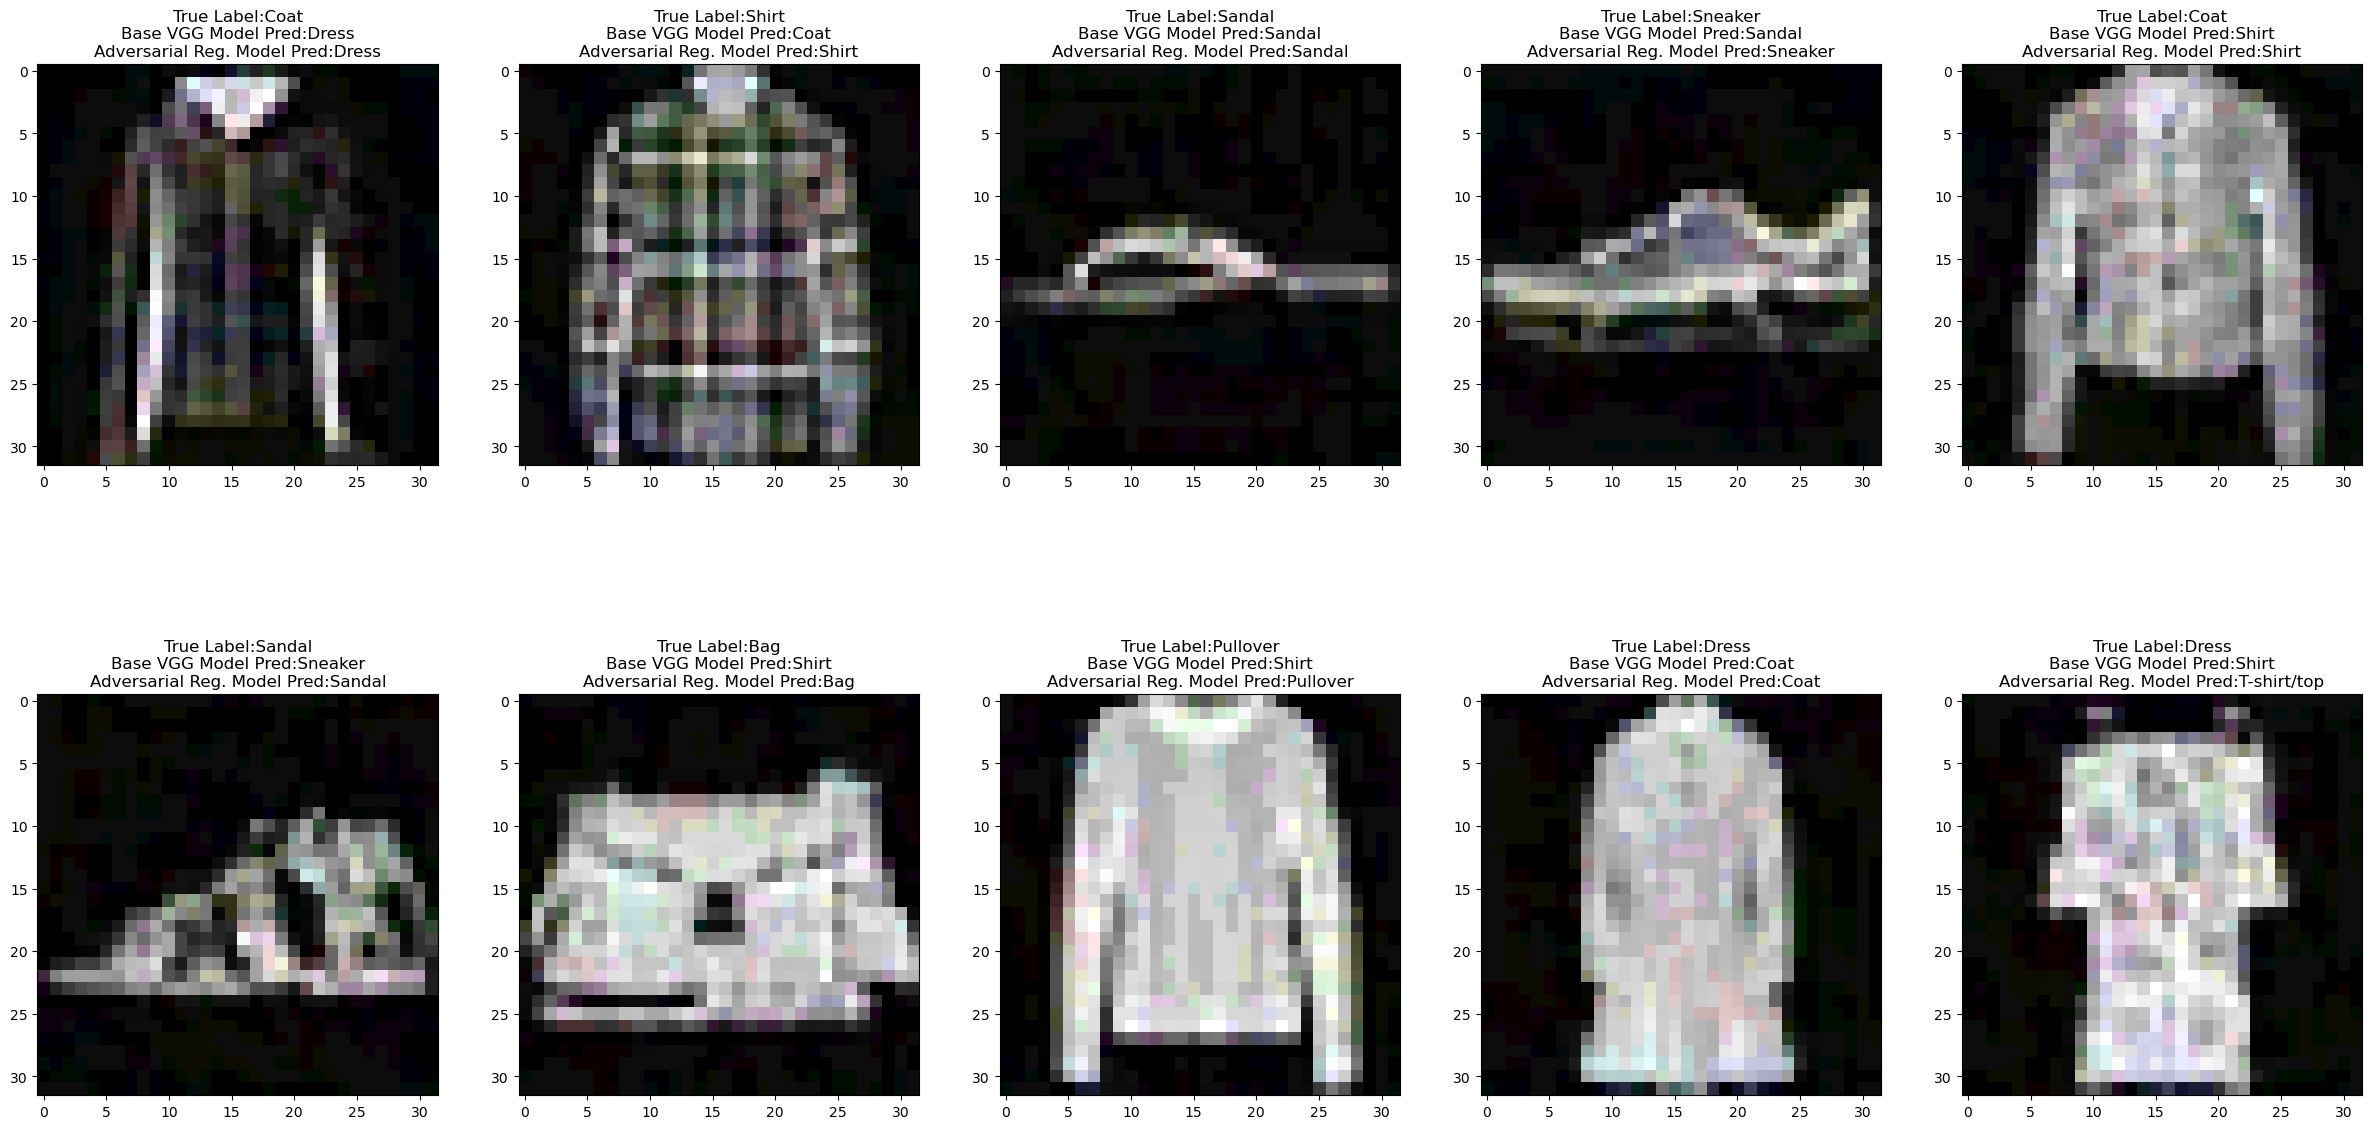

In [37]:
f, ax = plt.subplots(2, 5, figsize=(30, 15))
for idx, i in enumerate([6, 7, 8 , 9, 10, 11, 95, 99, 29, 33]):
  idx_x = idx // 5
  idx_y = idx % 5 

  sample_apparel_idx = i
  sample_apparel_img =  tf.convert_to_tensor([perturbed_test_imgs[sample_apparel_idx]])
  sample_apparel_labelidx = test_labels[sample_apparel_idx]

  bm_pred = get_model_preds(input_image=sample_apparel_img, 
                            class_names_map=class_names, 
                            model=model)[0]
  am_pred = get_model_preds(input_image=sample_apparel_img, 
                            class_names_map=class_names, 
                            model=adv_model.base_model)[0]

  ax[idx_x, idx_y].imshow(sample_apparel_img[0])
  ax[idx_x, idx_y].set_title('True Label:{}\nBase VGG Model Pred:{}\nAdversarial Reg. Model Pred:{}'.format(class_names[sample_apparel_labelidx],
                                                                                                            bm_pred,
                                                                                                            am_pred))
